In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import _pickle as cPickle
from PIL import Image
from sklearn.decomposition import PCA

In [3]:
def unpickle(file):
    fo = open(file, 'rb')
    dict = cPickle.load(fo, encoding='latin-1')
    fo.close()
    return dict

In [4]:
def display_image(sample_image):
    output = list()
    ratio = int(len(sample_image) / 3)

    red = sample_image[0:ratio]
    green = sample_image[ratio: 2*ratio]
    blue = sample_image[2*ratio:]

    for i in range(len(red)):
        val = list([red[i], green[i], blue[i]])
        output.append(val)

    output = np.array(output).reshape((32,32,3))
    print(output.shape)


    imgplot = plt.imshow(output)


In [5]:
#Read the data into python
batches = list()
column_names = unpickle("/home/jerry/CS498/cifar-10-batches-py/batches.meta")
batches.append(unpickle("/home/jerry/CS498/cifar-10-batches-py/data_batch_1"))
batches.append(unpickle("/home/jerry/CS498/cifar-10-batches-py/data_batch_2"))
batches.append(unpickle("/home/jerry/CS498/cifar-10-batches-py/data_batch_3"))
batches.append(unpickle("/home/jerry/CS498/cifar-10-batches-py/data_batch_4"))
batches.append(unpickle("/home/jerry/CS498/cifar-10-batches-py/data_batch_5"))
batches.append(unpickle("/home/jerry/CS498/cifar-10-batches-py/test_batch"))



In [6]:
#Combine the different batches into one dataset.
label_names = column_names['label_names']
merged_data = dict()
for data_batch in batches:
    raw_data  = data_batch['data']
    labels = data_batch['labels']
    for i in range(len(raw_data)):
        label = label_names[labels[i]]
        if (label not in merged_data):
            merged_data[label] = list()
        merged_data[label].append(raw_data[i])



In [7]:
print(merged_data.keys())
c = np.array(merged_data['bird'])
print(c.shape)

dict_keys(['frog', 'horse', 'airplane', 'bird', 'deer', 'truck', 'cat', 'automobile', 'ship', 'dog'])
(6000, 3072)


In [59]:
#Problem 4.10 Part A
errors_dict = dict()
var_err_dict = dict()
mean_image_dict = dict()
for key in merged_data:
    #Fit the data to the PCA and get the values.
    item = np.array(merged_data[key], dtype=np.uint8)
    val = np.mean(item, axis=0, dtype=int)
    mean_image_dict[key] = val
    pca_data = item.T
    pca = PCA(n_components = 20)
    PCs = pca.fit_transform(pca_data)
    cat_rest = pca.inverse_transform(PCs).T
    
    #Compute the errors.
    error = np.mean((item-cat_rest)**2)
    var_err = 1 - sum(pca.explained_variance_ratio_)
    errors_dict[key] = error
    var_err_dict[key] = var_err

    
    
    

    

In [61]:
print(errors_dict)
print(var_err_dict)

{'frog': 838.12834768381106, 'horse': 1096.930913828963, 'cat': 993.00475102476378, 'bird': 778.20390476513421, 'deer': 695.20070896240929, 'truck': 1281.2900630232139, 'airplane': 834.10936355450497, 'automobile': 1261.4996138852703, 'ship': 775.95338642435354, 'dog': 1026.8594704044783}
{'frog': 0.34266752787045796, 'horse': 0.32703012306189783, 'cat': 0.30658756150522315, 'bird': 0.32982336733232254, 'deer': 0.3121050130523555, 'truck': 0.30767095144411671, 'airplane': 0.28648962088926644, 'automobile': 0.33373688131073698, 'ship': 0.24175517054579132, 'dog': 0.31570326454203668}


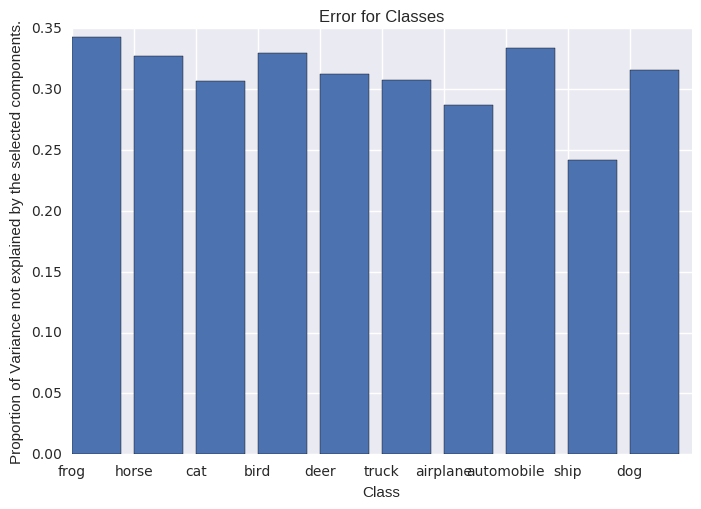

In [73]:
#Plot the values
import seaborn as sns
plt.bar(range(len(var_err_dict)), var_err_dict.values())
plt.xticks(range(len(var_err_dict)), var_err_dict.keys())
plt.xlabel("Class")
plt.ylabel("Proportion of Variance not explained by the selected components.")
plt.title("Error for Classes")

plt.show()
